# Village Health Digital Twin - Exploratory Data Analysis

This notebook explores the village health dataset containing:
- Household demographics and socioeconomic data
- Adult hypertension cases and interventions
- Child stunting and nutrition programs
- Program costs and effectiveness

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 1. Data Loading and Initial Exploration

In [2]:
# Load all datasets
households = pd.read_csv('HOUSEHOLDS.csv')
adults_htn = pd.read_csv('ADULTS_HTN.csv')
children_stunting = pd.read_csv('CHILDREN_STUNTING.csv')
program_log = pd.read_csv('PROGRAM_LOG.csv')
parameters = pd.read_csv('PARAMETERS.csv')
costs_catalog = pd.read_csv('COSTS_CATALOG.csv')
data_dictionary = pd.read_csv('DATA_DICTIONARY.csv')

print("Dataset Shapes:")
print(f"Households: {households.shape}")
print(f"Adults HTN: {adults_htn.shape}")
print(f"Children Stunting: {children_stunting.shape}")
print(f"Program Log: {program_log.shape}")
print(f"Parameters: {parameters.shape}")
print(f"Costs Catalog: {costs_catalog.shape}")

Dataset Shapes:
Households: (10, 6)
Adults HTN: (10, 22)
Children Stunting: (10, 24)
Program Log: (6, 6)
Parameters: (6, 3)
Costs Catalog: (8, 3)


In [3]:
# Dataset overview
def explore_dataset(df, name):
    print(f"\n=== {name.upper()} DATASET ===")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    print(f"\nFirst 3 rows:")
    display(df.head(3))

explore_dataset(households, "Households")


=== HOUSEHOLDS DATASET ===
Shape: (10, 6)

Columns: ['household_id', 'dusun', 'pendapatan_bulanan', 'air_bersih', 'jamban_sehat', 'jarak_ke_puskesmas_km']

Data Types:
household_id              object
dusun                     object
pendapatan_bulanan         int64
air_bersih                 int64
jamban_sehat               int64
jarak_ke_puskesmas_km    float64
dtype: object

Missing Values:
household_id             0
dusun                    0
pendapatan_bulanan       0
air_bersih               0
jamban_sehat             0
jarak_ke_puskesmas_km    0
dtype: int64

First 3 rows:


,household_id,dusun,pendapatan_bulanan,air_bersih,jamban_sehat,jarak_ke_puskesmas_km
0,HH001,Dusun A,1200000,0,0,6.5
1,HH002,Dusun A,900000,1,0,4.2
2,HH003,Dusun A,1500000,1,1,2.1


In [4]:
explore_dataset(adults_htn, "Adults Hypertension")


=== ADULTS HYPERTENSION DATASET ===
Shape: (10, 22)

Columns: ['person_id', 'household_id', 'sex', 'usia', 'sistol', 'diastol', 'diagnosis_htn', 'diabetes_koin', 'perokok', 'BMI', 'eligible_screening_htn', 'offered_htn_program', 'uptake_htn_program', 'adherence_htn', 'intensitas_kontrol_bln', 'jenis_obat', 'biaya_obat_bln', 'biaya_screening', 'biaya_kontrol_tahunan', 'biaya_transport_tahunan', 'penurunan_sbp_mmHg_12m', 'kejadian_stroke_MI']

Data Types:
person_id                   object
household_id                object
sex                         object
usia                         int64
sistol                       int64
diastol                      int64
diagnosis_htn                int64
diabetes_koin                int64
perokok                      int64
BMI                        float64
eligible_screening_htn       int64
offered_htn_program          int64
uptake_htn_program           int64
adherence_htn              float64
intensitas_kontrol_bln       int64
jenis_obat      

,person_id,household_id,sex,usia,sistol,diastol,diagnosis_htn,diabetes_koin,perokok,BMI,eligible_screening_htn,offered_htn_program,uptake_htn_program,adherence_htn,intensitas_kontrol_bln,jenis_obat,biaya_obat_bln,biaya_screening,biaya_kontrol_tahunan,biaya_transport_tahunan,penurunan_sbp_mmHg_12m,kejadian_stroke_MI
0,P001,HH001,M,58,155,96,1,0,1,27.5,1,1,1,0.75,1,ACEi,45000,30000,300000,150000,12,0
1,P002,HH002,F,61,162,98,1,0,0,30.2,1,1,1,0.85,1,CCB,55000,30000,360000,120000,15,0
2,P003,HH003,M,49,138,88,0,0,1,26.1,1,1,0,0.00,0,-,0,30000,0,0,0,0


In [5]:
explore_dataset(children_stunting, "Children Stunting")


=== CHILDREN STUNTING DATASET ===
Shape: (10, 24)

Columns: ['child_id', 'household_id', 'sex', 'usia_bulan', 'BB', 'TB', 'HAZ', 'WAZ', 'WHZ', 'ASI_eksklusif', 'mp_asi_memadai', 'anemia_hb_gdl', 'air_bersih', 'jamban_sehat', 'diare_3bln_terakhir', 'eligible_PMT_micronutrient', 'offered_stunting_program', 'uptake_stunting_program', 'intensitas_PMT_bln', 'kunjungan_posyandu_bln', 'delta_HAZ_12m', 'biaya_PMT_bln', 'biaya_mikronutrien_bln', 'biaya_WASH_bln']

Data Types:
child_id                       object
household_id                   object
sex                            object
usia_bulan                      int64
BB                            float64
TB                            float64
HAZ                           float64
WAZ                           float64
WHZ                           float64
ASI_eksklusif                   int64
mp_asi_memadai                  int64
anemia_hb_gdl                 float64
air_bersih                      int64
jamban_sehat                    i

,child_id,household_id,sex,usia_bulan,BB,TB,HAZ,WAZ,WHZ,ASI_eksklusif,mp_asi_memadai,anemia_hb_gdl,air_bersih,jamban_sehat,diare_3bln_terakhir,eligible_PMT_micronutrient,offered_stunting_program,uptake_stunting_program,intensitas_PMT_bln,kunjungan_posyandu_bln,delta_HAZ_12m,biaya_PMT_bln,biaya_mikronutrien_bln,biaya_WASH_bln
0,C001,HH001,F,16,8.2,73.0,-2.3,-1.5,-1.1,1,0,10.2,0,0,1,1,1,1,2,1,0.4,45000,20000,15000
1,C002,HH002,M,22,9.0,77.5,-1.9,-1.2,-0.8,1,1,10.8,1,0,0,1,1,1,2,1,0.3,45000,20000,0
2,C003,HH003,F,10,6.1,67.2,-2.8,-1.9,-1.4,0,0,9.7,1,1,1,1,1,0,0,1,0.1,45000,20000,15000


## 2. Health Indicators and Thresholds Definition

In [6]:
# Define health thresholds based on WHO/national standards
HEALTH_THRESHOLDS = {
    'stunting_critical': -2.0,  # HAZ < -2 indicates stunting
    'stunting_severe': -3.0,   # HAZ < -3 indicates severe stunting
    'htn_systolic': 140,       # SBP ≥ 140 mmHg
    'htn_diastolic': 90,       # DBP ≥ 90 mmHg
    'anemia_threshold': 11.0,  # Hb < 11 g/dL for children
    'low_income': 1000000,     # Monthly income < 1M IDR
    'distance_far': 5.0        # Distance > 5km to health facility
}

# Create village-level aggregated metrics
def create_village_metrics():
    # Aggregate by dusun (village)
    village_metrics = []
    
    for dusun in households['dusun'].unique():
        # Household data for this village
        hh_village = households[households['dusun'] == dusun]
        adults_village = adults_htn[adults_htn['household_id'].isin(hh_village['household_id'])]
        children_village = children_stunting[children_stunting['household_id'].isin(hh_village['household_id'])]
        
        metrics = {
            'dusun': dusun,
            'total_households': len(hh_village),
            'total_adults': len(adults_village),
            'total_children': len(children_village),
            
            # Socioeconomic indicators
            'avg_income': hh_village['pendapatan_bulanan'].mean(),
            'low_income_pct': (hh_village['pendapatan_bulanan'] < HEALTH_THRESHOLDS['low_income']).mean() * 100,
            'clean_water_pct': hh_village['air_bersih'].mean() * 100,
            'sanitation_pct': hh_village['jamban_sehat'].mean() * 100,
            'avg_distance_puskesmas': hh_village['jarak_ke_puskesmas_km'].mean(),
            
            # Hypertension indicators
            'htn_prevalence': adults_village['diagnosis_htn'].mean() * 100 if len(adults_village) > 0 else 0,
            'htn_controlled': adults_village[adults_village['diagnosis_htn'] == 1]['adherence_htn'].mean() * 100 if len(adults_village[adults_village['diagnosis_htn'] == 1]) > 0 else 0,
            'avg_systolic': adults_village['sistol'].mean() if len(adults_village) > 0 else 0,
            
            # Stunting indicators
            'stunting_prevalence': (children_village['HAZ'] < HEALTH_THRESHOLDS['stunting_critical']).mean() * 100 if len(children_village) > 0 else 0,
            'severe_stunting_prevalence': (children_village['HAZ'] < HEALTH_THRESHOLDS['stunting_severe']).mean() * 100 if len(children_village) > 0 else 0,
            'avg_HAZ': children_village['HAZ'].mean() if len(children_village) > 0 else 0,
            'anemia_prevalence': (children_village['anemia_hb_gdl'] < HEALTH_THRESHOLDS['anemia_threshold']).mean() * 100 if len(children_village) > 0 else 0,
            'exclusive_breastfeeding_pct': children_village['ASI_eksklusif'].mean() * 100 if len(children_village) > 0 else 0,
        }
        
        village_metrics.append(metrics)
    
    return pd.DataFrame(village_metrics)

village_df = create_village_metrics()
display(village_df)

,dusun,total_households,total_adults,total_children,avg_income,low_income_pct,clean_water_pct,sanitation_pct,avg_distance_puskesmas,htn_prevalence,htn_controlled,avg_systolic,stunting_prevalence,severe_stunting_prevalence,avg_HAZ,anemia_prevalence,exclusive_breastfeeding_pct
0,Dusun A,3,3,3,1200000.0,33.333333,66.666667,33.333333,4.266667,66.666667,80.000000,151.666667,66.666667,0.0,-2.333333,100.000000,66.666667
1,Dusun B,3,3,3,1300000.0,33.333333,66.666667,33.333333,4.366667,100.000000,61.666667,164.666667,66.666667,0.0,-2.100000,66.666667,66.666667
2,Dusun C,4,4,4,1175000.0,50.000000,50.000000,25.000000,6.500000,75.000000,48.333333,156.250000,75.000000,0.0,-2.275000,75.000000,75.000000


## 3. Risk Classification System

In [7]:
# Define risk classification function
def classify_risk(value, metric_type):
    """Classify health metrics into Normal, Warning, Critical zones"""
    if metric_type == 'stunting_prevalence':
        if value >= 30: return 'Critical'
        elif value >= 20: return 'Warning'
        else: return 'Normal'
    
    elif metric_type == 'htn_prevalence':
        if value >= 25: return 'Critical'
        elif value >= 15: return 'Warning'
        else: return 'Normal'
    
    elif metric_type == 'clean_water_pct':
        if value < 50: return 'Critical'
        elif value < 80: return 'Warning'
        else: return 'Normal'
    
    elif metric_type == 'low_income_pct':
        if value >= 60: return 'Critical'
        elif value >= 40: return 'Warning'
        else: return 'Normal'
    
    elif metric_type == 'distance_puskesmas':
        if value >= 8: return 'Critical'
        elif value >= 5: return 'Warning'
        else: return 'Normal'
    
    return 'Unknown'

# Apply risk classification
village_df['stunting_risk'] = village_df['stunting_prevalence'].apply(lambda x: classify_risk(x, 'stunting_prevalence'))
village_df['htn_risk'] = village_df['htn_prevalence'].apply(lambda x: classify_risk(x, 'htn_prevalence'))
village_df['water_risk'] = village_df['clean_water_pct'].apply(lambda x: classify_risk(x, 'clean_water_pct'))
village_df['income_risk'] = village_df['low_income_pct'].apply(lambda x: classify_risk(x, 'low_income_pct'))
village_df['distance_risk'] = village_df['avg_distance_puskesmas'].apply(lambda x: classify_risk(x, 'distance_puskesmas'))

# Overall health risk score (weighted)
risk_weights = {'Critical': 3, 'Warning': 2, 'Normal': 1}
village_df['health_risk_score'] = (
    village_df['stunting_risk'].map(risk_weights) * 0.3 +
    village_df['htn_risk'].map(risk_weights) * 0.25 +
    village_df['water_risk'].map(risk_weights) * 0.2 +
    village_df['income_risk'].map(risk_weights) * 0.15 +
    village_df['distance_risk'].map(risk_weights) * 0.1
)

def overall_risk_category(score):
    if score >= 2.5: return 'Critical'
    elif score >= 1.8: return 'Warning'
    else: return 'Normal'

village_df['overall_risk'] = village_df['health_risk_score'].apply(overall_risk_category)

print("Village Risk Assessment:")
display(village_df[['dusun', 'stunting_risk', 'htn_risk', 'water_risk', 'income_risk', 'distance_risk', 'overall_risk', 'health_risk_score']])

Village Risk Assessment:


,dusun,stunting_risk,htn_risk,water_risk,income_risk,distance_risk,overall_risk,health_risk_score
0,Dusun A,Critical,Critical,Warning,Normal,Normal,Warning,2.30
1,Dusun B,Critical,Critical,Warning,Normal,Normal,Warning,2.30
2,Dusun C,Critical,Critical,Warning,Warning,Warning,Critical,2.55


## 4. Comprehensive Data Visualization

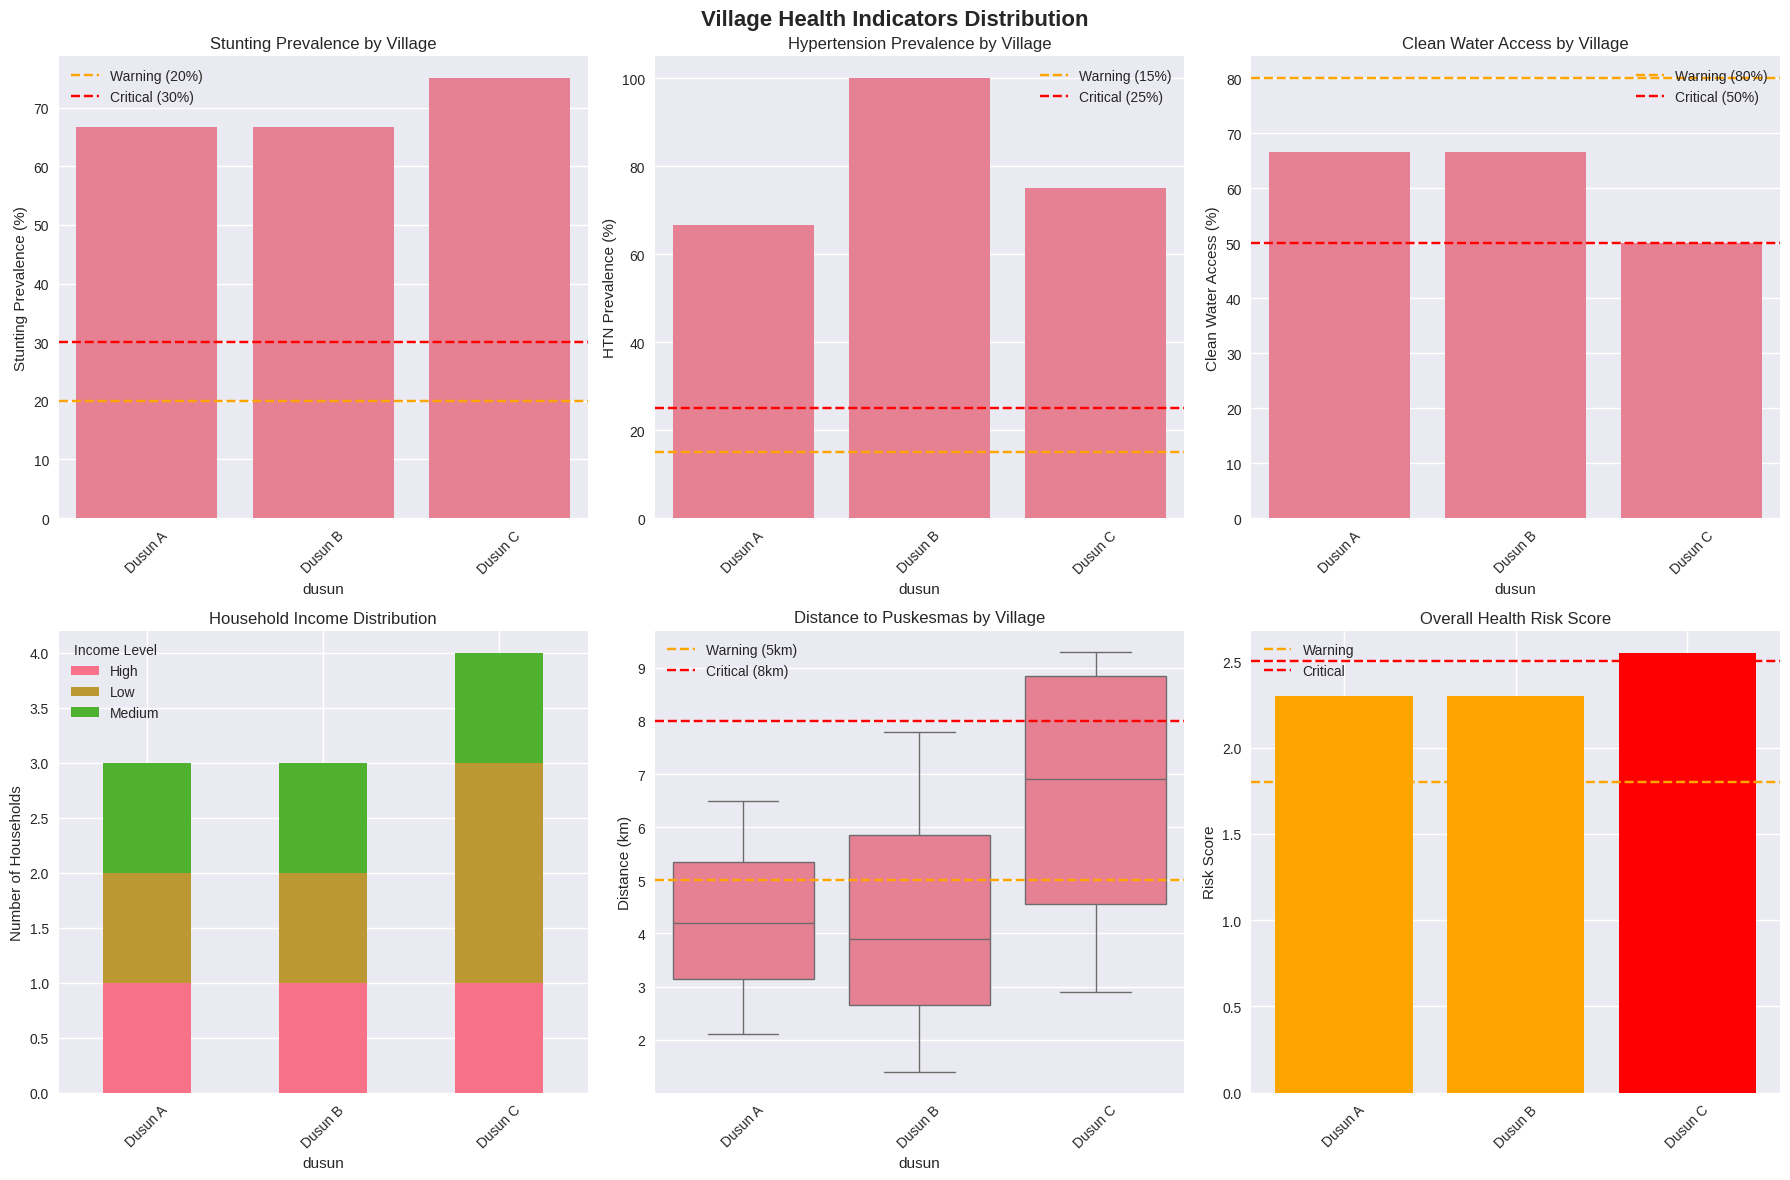

In [8]:
# Set up the plotting environment
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Village Health Indicators Distribution', fontsize=16, fontweight='bold')

# 1. Stunting Prevalence by Village
sns.barplot(data=village_df, x='dusun', y='stunting_prevalence', ax=axes[0,0])
axes[0,0].set_title('Stunting Prevalence by Village')
axes[0,0].set_ylabel('Stunting Prevalence (%)')
axes[0,0].axhline(y=20, color='orange', linestyle='--', label='Warning (20%)')
axes[0,0].axhline(y=30, color='red', linestyle='--', label='Critical (30%)')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Hypertension Prevalence by Village
sns.barplot(data=village_df, x='dusun', y='htn_prevalence', ax=axes[0,1])
axes[0,1].set_title('Hypertension Prevalence by Village')
axes[0,1].set_ylabel('HTN Prevalence (%)')
axes[0,1].axhline(y=15, color='orange', linestyle='--', label='Warning (15%)')
axes[0,1].axhline(y=25, color='red', linestyle='--', label='Critical (25%)')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Clean Water Access by Village
sns.barplot(data=village_df, x='dusun', y='clean_water_pct', ax=axes[0,2])
axes[0,2].set_title('Clean Water Access by Village')
axes[0,2].set_ylabel('Clean Water Access (%)')
axes[0,2].axhline(y=80, color='orange', linestyle='--', label='Warning (80%)')
axes[0,2].axhline(y=50, color='red', linestyle='--', label='Critical (50%)')
axes[0,2].legend()
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Income Distribution
households['income_category'] = households['pendapatan_bulanan'].apply(
    lambda x: 'Low' if x < 1000000 else 'Medium' if x < 1500000 else 'High'
)
income_dist = households.groupby(['dusun', 'income_category']).size().unstack(fill_value=0)
income_dist.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Household Income Distribution')
axes[1,0].set_ylabel('Number of Households')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Income Level')

# 5. Distance to Health Facilities
sns.boxplot(data=households, x='dusun', y='jarak_ke_puskesmas_km', ax=axes[1,1])
axes[1,1].set_title('Distance to Puskesmas by Village')
axes[1,1].set_ylabel('Distance (km)')
axes[1,1].axhline(y=5, color='orange', linestyle='--', label='Warning (5km)')
axes[1,1].axhline(y=8, color='red', linestyle='--', label='Critical (8km)')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Overall Risk Assessment
risk_colors = {'Normal': 'green', 'Warning': 'orange', 'Critical': 'red'}
colors = [risk_colors[risk] for risk in village_df['overall_risk']]
axes[1,2].bar(village_df['dusun'], village_df['health_risk_score'], color=colors)
axes[1,2].set_title('Overall Health Risk Score')
axes[1,2].set_ylabel('Risk Score')
axes[1,2].axhline(y=1.8, color='orange', linestyle='--', label='Warning')
axes[1,2].axhline(y=2.5, color='red', linestyle='--', label='Critical')
axes[1,2].legend()
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

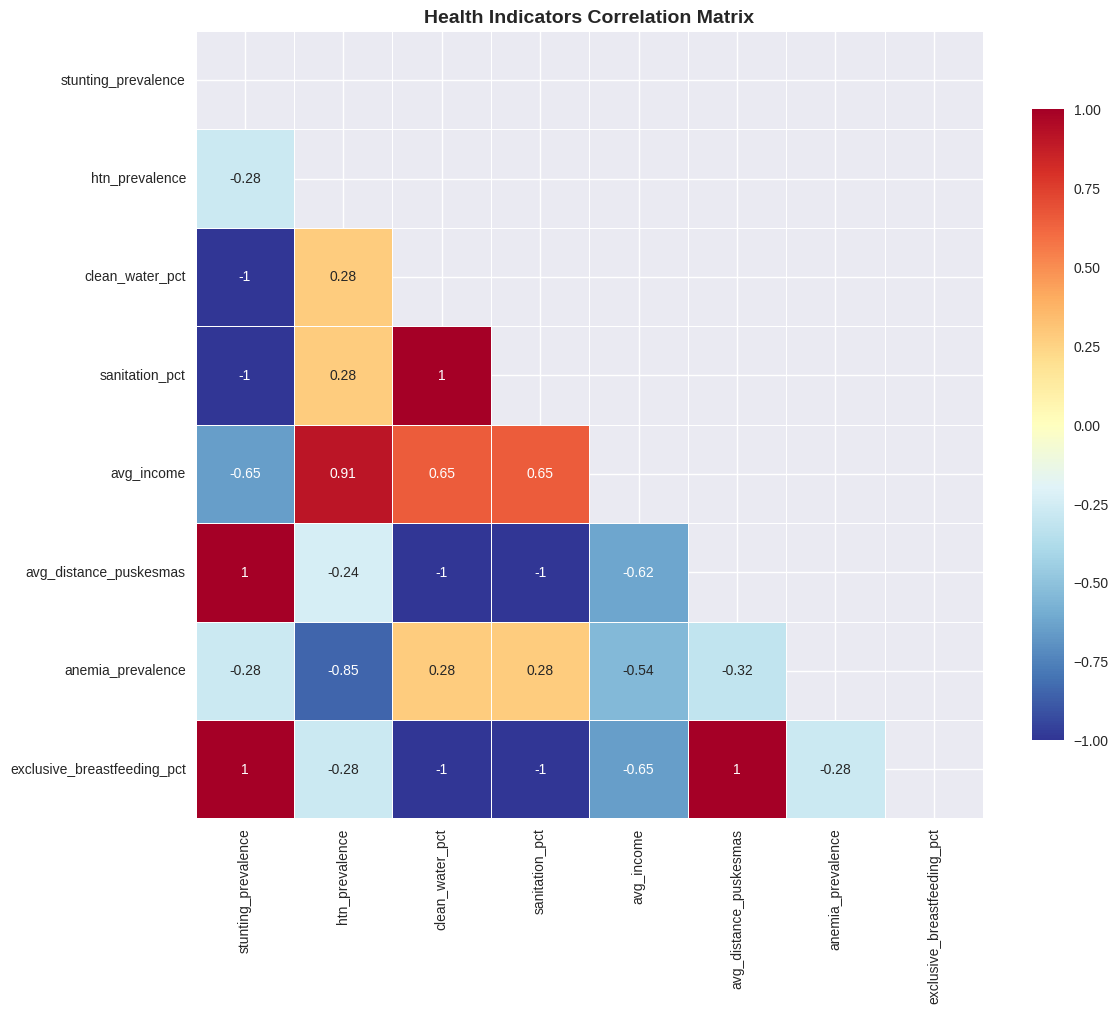


Strongest Correlations (|r| > 0.5):
avg_distance_puskesmas vs stunting_prevalence: 0.999
stunting_prevalence vs avg_distance_puskesmas: 0.999
avg_distance_puskesmas vs exclusive_breastfeeding_pct: 0.999
exclusive_breastfeeding_pct vs avg_distance_puskesmas: 0.999
htn_prevalence vs avg_income: 0.908
avg_income vs htn_prevalence: 0.908
sanitation_pct vs avg_income: 0.655
clean_water_pct vs avg_income: 0.655
avg_income vs sanitation_pct: 0.655
avg_income vs clean_water_pct: 0.655
avg_income vs anemia_prevalence: -0.545
anemia_prevalence vs avg_income: -0.545
avg_distance_puskesmas vs avg_income: -0.624
avg_income vs avg_distance_puskesmas: -0.624
exclusive_breastfeeding_pct vs avg_income: -0.655
avg_income vs exclusive_breastfeeding_pct: -0.655
avg_income vs stunting_prevalence: -0.655
stunting_prevalence vs avg_income: -0.655
htn_prevalence vs anemia_prevalence: -0.846
anemia_prevalence vs htn_prevalence: -0.846
avg_distance_puskesmas vs clean_water_pct: -0.999
avg_distance_puskesmas vs

In [9]:
# Correlation heatmap of key health indicators
correlation_vars = [
    'stunting_prevalence', 'htn_prevalence', 'clean_water_pct', 
    'sanitation_pct', 'avg_income', 'avg_distance_puskesmas',
    'anemia_prevalence', 'exclusive_breastfeeding_pct'
]

plt.figure(figsize=(12, 10))
correlation_matrix = village_df[correlation_vars].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Health Indicators Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print strongest correlations
print("\nStrongest Correlations (|r| > 0.5):")
correlations = correlation_matrix.unstack().sort_values(ascending=False)
strong_corr = correlations[(correlations.abs() > 0.5) & (correlations != 1.0)]
for (var1, var2), corr in strong_corr.items():
    print(f"{var1} vs {var2}: {corr:.3f}")

## 6. Individual-Level Analysis

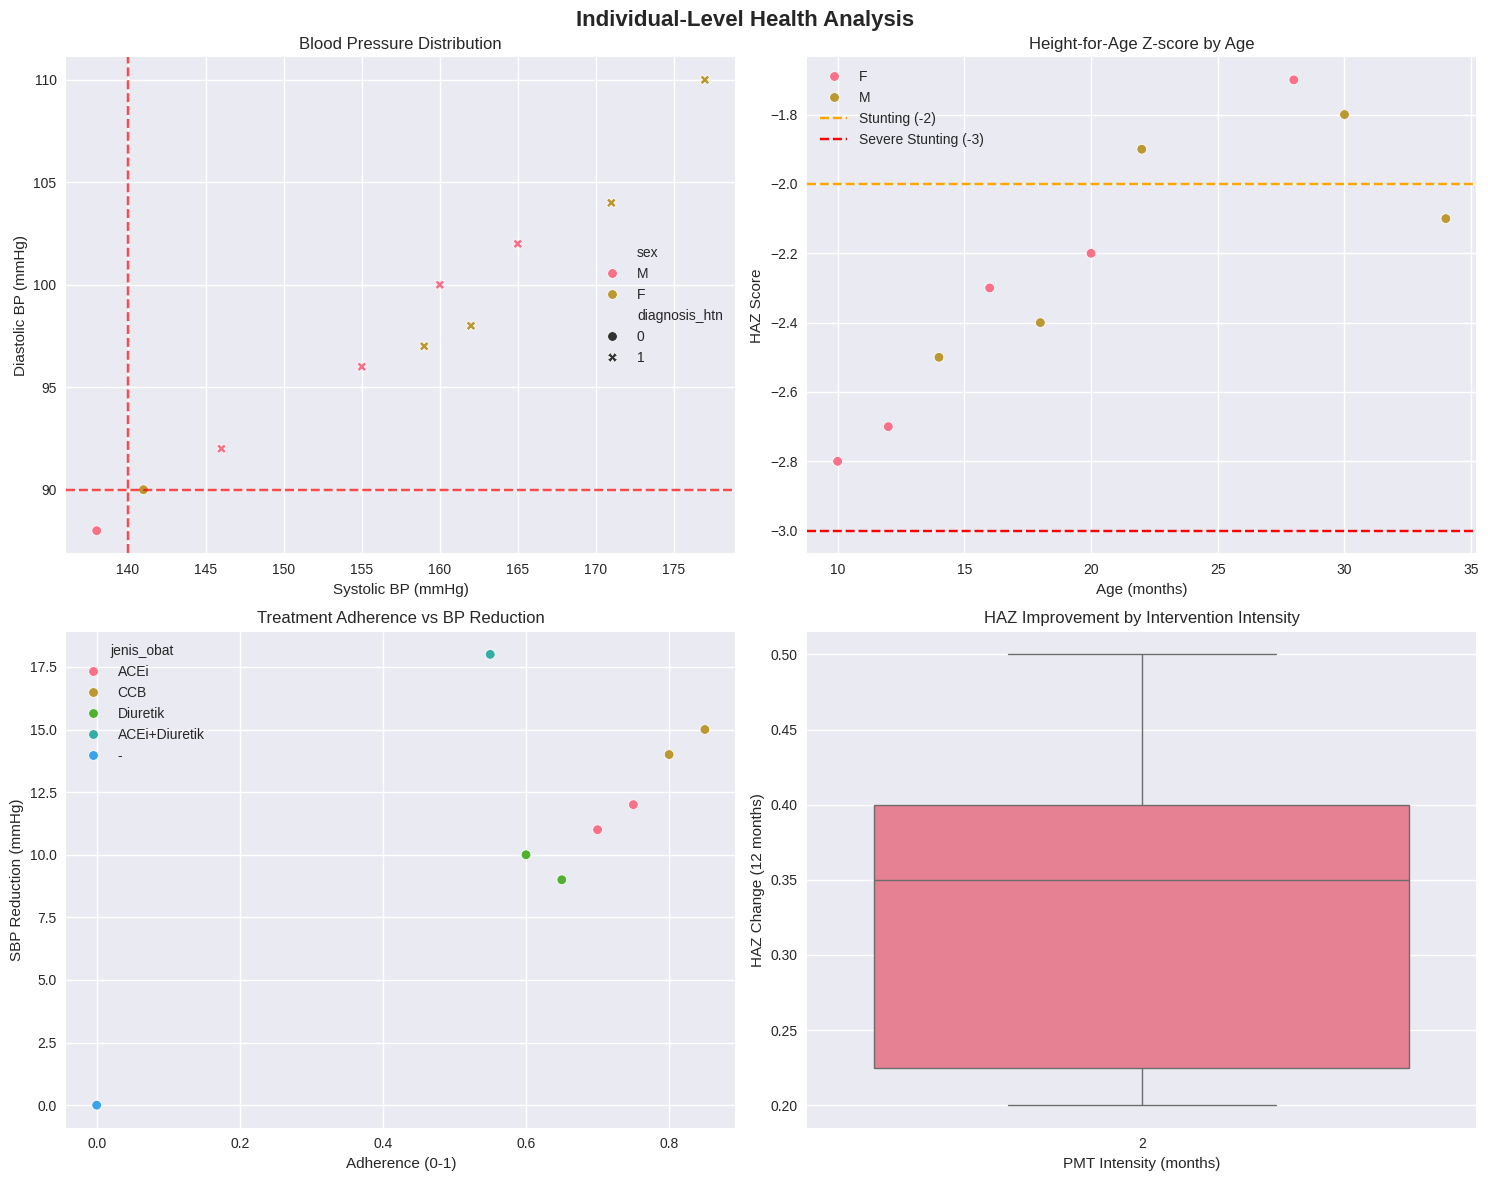

In [10]:
# Individual-level analysis for adults and children
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Individual-Level Health Analysis', fontsize=16, fontweight='bold')

# 1. Blood pressure distribution by gender
sns.scatterplot(data=adults_htn, x='sistol', y='diastol', hue='sex', 
                style='diagnosis_htn', ax=axes[0,0])
axes[0,0].axvline(x=140, color='red', linestyle='--', alpha=0.7)
axes[0,0].axhline(y=90, color='red', linestyle='--', alpha=0.7)
axes[0,0].set_title('Blood Pressure Distribution')
axes[0,0].set_xlabel('Systolic BP (mmHg)')
axes[0,0].set_ylabel('Diastolic BP (mmHg)')

# 2. HAZ distribution by age
sns.scatterplot(data=children_stunting, x='usia_bulan', y='HAZ', 
                hue='sex', ax=axes[0,1])
axes[0,1].axhline(y=-2, color='orange', linestyle='--', label='Stunting (-2)')
axes[0,1].axhline(y=-3, color='red', linestyle='--', label='Severe Stunting (-3)')
axes[0,1].set_title('Height-for-Age Z-score by Age')
axes[0,1].set_xlabel('Age (months)')
axes[0,1].set_ylabel('HAZ Score')
axes[0,1].legend()

# 3. Treatment adherence vs BP control
htn_treated = adults_htn[adults_htn['diagnosis_htn'] == 1]
sns.scatterplot(data=htn_treated, x='adherence_htn', y='penurunan_sbp_mmHg_12m',
                hue='jenis_obat', ax=axes[1,0])
axes[1,0].set_title('Treatment Adherence vs BP Reduction')
axes[1,0].set_xlabel('Adherence (0-1)')
axes[1,0].set_ylabel('SBP Reduction (mmHg)')

# 4. HAZ improvement by intervention
children_intervention = children_stunting[children_stunting['uptake_stunting_program'] == 1]
sns.boxplot(data=children_intervention, x='intensitas_PMT_bln', y='delta_HAZ_12m', ax=axes[1,1])
axes[1,1].set_title('HAZ Improvement by Intervention Intensity')
axes[1,1].set_xlabel('PMT Intensity (months)')
axes[1,1].set_ylabel('HAZ Change (12 months)')

plt.tight_layout()
plt.show()

## 7. Program Effectiveness Analysis

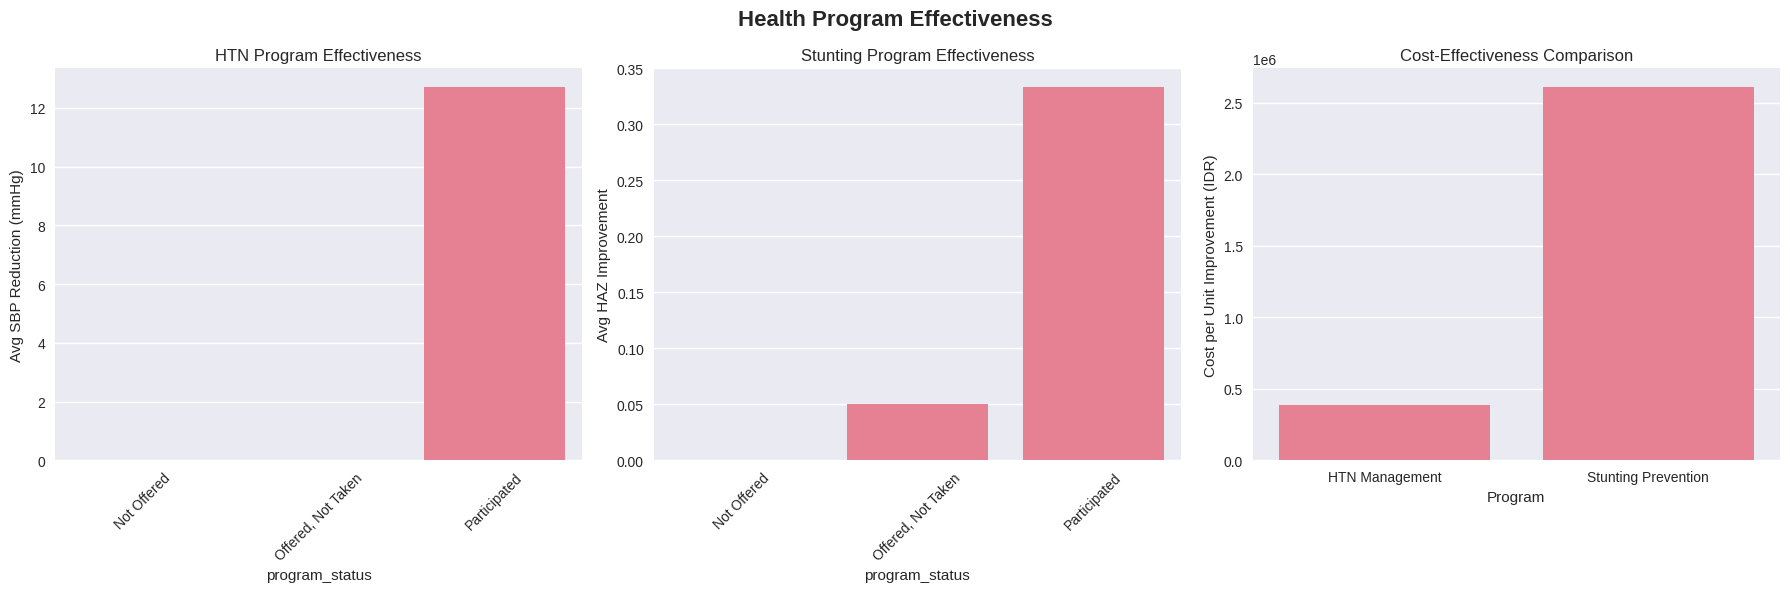


Program Effectiveness Summary:
HTN Program: 388,989 IDR per mmHg SBP reduction
Stunting Program: 2,610,000 IDR per HAZ point improvement


In [11]:
# Program effectiveness analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Health Program Effectiveness', fontsize=16, fontweight='bold')

# 1. HTN Program Uptake vs Outcomes
htn_program_data = adults_htn.groupby(['offered_htn_program', 'uptake_htn_program']).agg({
    'penurunan_sbp_mmHg_12m': 'mean',
    'person_id': 'count'
}).reset_index()
htn_program_data['program_status'] = htn_program_data.apply(
    lambda x: 'Not Offered' if x['offered_htn_program'] == 0 
    else 'Offered, Not Taken' if x['uptake_htn_program'] == 0 
    else 'Participated', axis=1
)

sns.barplot(data=htn_program_data, x='program_status', y='penurunan_sbp_mmHg_12m', ax=axes[0])
axes[0].set_title('HTN Program Effectiveness')
axes[0].set_ylabel('Avg SBP Reduction (mmHg)')
axes[0].tick_params(axis='x', rotation=45)

# 2. Stunting Program Uptake vs Outcomes
stunting_program_data = children_stunting.groupby(['offered_stunting_program', 'uptake_stunting_program']).agg({
    'delta_HAZ_12m': 'mean',
    'child_id': 'count'
}).reset_index()
stunting_program_data['program_status'] = stunting_program_data.apply(
    lambda x: 'Not Offered' if x['offered_stunting_program'] == 0 
    else 'Offered, Not Taken' if x['uptake_stunting_program'] == 0 
    else 'Participated', axis=1
)

sns.barplot(data=stunting_program_data, x='program_status', y='delta_HAZ_12m', ax=axes[1])
axes[1].set_title('Stunting Program Effectiveness')
axes[1].set_ylabel('Avg HAZ Improvement')
axes[1].tick_params(axis='x', rotation=45)

# 3. Cost-effectiveness analysis
# Calculate cost per case improved
htn_participants = adults_htn[adults_htn['uptake_htn_program'] == 1]
avg_htn_cost = htn_participants[['biaya_obat_bln', 'biaya_screening', 'biaya_kontrol_tahunan']].sum(axis=1).mean() * 12
avg_bp_reduction = htn_participants['penurunan_sbp_mmHg_12m'].mean()
htn_cost_effectiveness = avg_htn_cost / avg_bp_reduction if avg_bp_reduction > 0 else 0

stunting_participants = children_stunting[children_stunting['uptake_stunting_program'] == 1]
avg_stunting_cost = stunting_participants[['biaya_PMT_bln', 'biaya_mikronutrien_bln', 'biaya_WASH_bln']].sum(axis=1).mean() * 12
avg_haz_improvement = stunting_participants['delta_HAZ_12m'].mean()
stunting_cost_effectiveness = avg_stunting_cost / avg_haz_improvement if avg_haz_improvement > 0 else 0

cost_eff_data = pd.DataFrame({
    'Program': ['HTN Management', 'Stunting Prevention'],
    'Cost_per_Unit_Improvement': [htn_cost_effectiveness, stunting_cost_effectiveness],
    'Unit': ['IDR per mmHg reduced', 'IDR per HAZ point improved']
})

sns.barplot(data=cost_eff_data, x='Program', y='Cost_per_Unit_Improvement', ax=axes[2])
axes[2].set_title('Cost-Effectiveness Comparison')
axes[2].set_ylabel('Cost per Unit Improvement (IDR)')
axes[2].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

print(f"\nProgram Effectiveness Summary:")
print(f"HTN Program: {htn_cost_effectiveness:,.0f} IDR per mmHg SBP reduction")
print(f"Stunting Program: {stunting_cost_effectiveness:,.0f} IDR per HAZ point improvement")

## 8. Interactive Dashboard Overview

In [12]:
# Replace cell 12 (Interactive Dashboard Overview) with this corrected version:

# Create interactive dashboard using Plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplot structure - using "polar" instead of "radar"
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Village Risk Assessment', 'Health Indicators by Village', 
                   'Program Coverage', 'Cost vs Effectiveness'),
    specs=[[{"type": "bar"}, {"type": "polar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# 1. Village Risk Assessment
risk_colors_map = {'Normal': 'green', 'Warning': 'orange', 'Critical': 'red'}
colors = [risk_colors_map[risk] for risk in village_df['overall_risk']]

fig.add_trace(
    go.Bar(x=village_df['dusun'], y=village_df['health_risk_score'],
           marker_color=colors, name='Risk Score',
           text=village_df['overall_risk'], textposition='outside',
           showlegend=False),
    row=1, col=1
)

# 2. Radar chart for health indicators - using Scatterpolar
categories = ['Stunting Prev.', 'HTN Prev.', 'Clean Water', 'Sanitation', 'Income Level']

for idx, dusun in enumerate(village_df['dusun']):
    row_data = village_df[village_df['dusun'] == dusun].iloc[0]
    values = [
        row_data['stunting_prevalence'],
        row_data['htn_prevalence'], 
        row_data['clean_water_pct'],
        row_data['sanitation_pct'],
        100 - row_data['low_income_pct']  # Invert for better visualization
    ]
    
    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=categories,
            fill='toself',
            name=dusun,
            line_color=px.colors.qualitative.Set1[idx],
            opacity=0.7
        ),
        row=1, col=2
    )

# 3. Program Coverage
coverage_data = pd.DataFrame({
    'Program': ['HTN Screening', 'HTN Treatment', 'Stunting PMT', 'Micronutrients'],
    'Offered': [
        adults_htn['offered_htn_program'].sum(),
        adults_htn['uptake_htn_program'].sum(),
        children_stunting['offered_stunting_program'].sum(),
        children_stunting['uptake_stunting_program'].sum()
    ],
    'Total_Eligible': [
        adults_htn['eligible_screening_htn'].sum(),
        adults_htn['eligible_screening_htn'].sum(),
        children_stunting['eligible_PMT_micronutrient'].sum(),
        children_stunting['eligible_PMT_micronutrient'].sum()
    ]
})
coverage_data['Coverage_Pct'] = (coverage_data['Offered'] / coverage_data['Total_Eligible']) * 100

fig.add_trace(
    go.Bar(x=coverage_data['Program'], y=coverage_data['Coverage_Pct'],
           name='Coverage %', marker_color='lightblue',
           showlegend=False),
    row=2, col=1
)

# 4. Cost vs Effectiveness scatter
# Add individual program data points
programs_cost_eff = pd.DataFrame({
    'Program': ['HTN Management', 'Stunting Prevention'],
    'Annual_Cost': [avg_htn_cost, avg_stunting_cost],
    'Effectiveness': [avg_bp_reduction, avg_haz_improvement * 10]  # Scale HAZ for visibility
})

fig.add_trace(
    go.Scatter(x=programs_cost_eff['Annual_Cost'], y=programs_cost_eff['Effectiveness'],
               mode='markers+text', text=programs_cost_eff['Program'],
               textposition='top center', marker_size=15,
               name='Programs', marker_color='red'),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="Village Health Digital Twin - Dashboard Overview",
    title_x=0.5,
    height=800,
    showlegend=True
)

# Update axes labels
fig.update_xaxes(title_text="Village", row=1, col=1)
fig.update_yaxes(title_text="Risk Score", row=1, col=1)

# Update polar chart
fig.update_polars(
    radialaxis=dict(visible=True, range=[0, 100]),
    row=1, col=2
)

fig.update_xaxes(title_text="Program", row=2, col=1)
fig.update_yaxes(title_text="Coverage (%)", row=2, col=1)

fig.update_xaxes(title_text="Annual Cost (IDR)", row=2, col=2)
fig.update_yaxes(title_text="Effectiveness Score", row=2, col=2)

fig.show()

# Alternative: Create separate radar chart if the above doesn't work well
print("\n=== Creating Alternative Radar Chart ===")

# Standalone radar chart for better visualization
radar_fig = go.Figure()

for idx, dusun in enumerate(village_df['dusun']):
    row_data = village_df[village_df['dusun'] == dusun].iloc[0]
    values = [
        row_data['stunting_prevalence'],
        row_data['htn_prevalence'], 
        row_data['clean_water_pct'],
        row_data['sanitation_pct'],
        100 - row_data['low_income_pct'],
        row_data['stunting_prevalence']  # Close the radar
    ]
    
    categories_closed = categories + [categories[0]]  # Close the radar
    
    radar_fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories_closed,
        fill='toself',
        name=dusun,
        line_color=px.colors.qualitative.Set1[idx]
    ))

radar_fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )),
    title="Health Indicators Comparison by Village",
    showlegend=True
)

radar_fig.show()

# Summary statistics table
print("\n=== VILLAGE HEALTH SUMMARY ===")
summary_stats = village_df.groupby('overall_risk').agg({
    'dusun': 'count',
    'total_households': 'sum',
    'stunting_prevalence': 'mean',
    'htn_prevalence': 'mean',
    'clean_water_pct': 'mean'
}).round(1)
summary_stats.columns = ['Villages', 'Total HH', 'Avg Stunting %', 'Avg HTN %', 'Avg Clean Water %']
display(summary_stats)


=== Creating Alternative Radar Chart ===



=== VILLAGE HEALTH SUMMARY ===


,Villages,Total HH,Avg Stunting %,Avg HTN %,Avg Clean Water %
overall_risk,,,,,
Critical,1,4,75.0,75.0,50.0
Warning,2,6,66.7,83.3,66.7


## 9. Key Insights and Recommendations

In [13]:
# Generate automated insights
def generate_insights(village_df, adults_htn, children_stunting):
    insights = []
    
    # Village-level insights
    critical_villages = village_df[village_df['overall_risk'] == 'Critical']['dusun'].tolist()
    if critical_villages:
        insights.append(f"🚨 CRITICAL: {', '.join(critical_villages)} require immediate intervention")
    
    # Health burden insights
    avg_stunting = village_df['stunting_prevalence'].mean()
    avg_htn = village_df['htn_prevalence'].mean()
    
    if avg_stunting > 20:
        insights.append(f"📊 Village-wide stunting prevalence ({avg_stunting:.1f}%) exceeds WHO emergency threshold (20%)")
    
    if avg_htn > 25:
        insights.append(f"💔 Hypertension prevalence ({avg_htn:.1f}%) indicates high cardiovascular risk")
    
    # Infrastructure insights
    low_water_villages = village_df[village_df['clean_water_pct'] < 80]['dusun'].tolist()
    if low_water_villages:
        insights.append(f"💧 Water access issues in: {', '.join(low_water_villages)}")
    
    # Program effectiveness insights
    htn_effectiveness = adults_htn[adults_htn['uptake_htn_program'] == 1]['penurunan_sbp_mmHg_12m'].mean()
    stunting_effectiveness = children_stunting[children_stunting['uptake_stunting_program'] == 1]['delta_HAZ_12m'].mean()
    
    if htn_effectiveness > 10:
        insights.append(f"✅ HTN program shows good effectiveness ({htn_effectiveness:.1f} mmHg avg reduction)")
    
    if stunting_effectiveness > 0.3:
        insights.append(f"✅ Stunting program shows positive impact ({stunting_effectiveness:.2f} HAZ improvement)")
    
    # Coverage gaps
    htn_coverage = (adults_htn['offered_htn_program'].sum() / adults_htn['eligible_screening_htn'].sum()) * 100
    stunting_coverage = (children_stunting['offered_stunting_program'].sum() / children_stunting['eligible_PMT_micronutrient'].sum()) * 100
    
    if htn_coverage < 80:
        insights.append(f"⚠️ HTN program coverage gap: only {htn_coverage:.1f}% of eligible adults reached")
    
    if stunting_coverage < 80:
        insights.append(f"⚠️ Stunting program coverage gap: only {stunting_coverage:.1f}% of eligible children reached")
    
    return insights

insights = generate_insights(village_df, adults_htn, children_stunting)

print("=== KEY INSIGHTS & RECOMMENDATIONS ===")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\n=== PRIORITY ACTIONS ===")
print("1. 🎯 Target critical villages for immediate multi-sectoral intervention")
print("2. 💧 Prioritize water and sanitation infrastructure in low-access areas")
print("3. 📈 Scale up effective programs with demonstrated impact")
print("4. 🔄 Improve program coverage to reach more eligible beneficiaries")
print("5. 💰 Optimize resource allocation based on cost-effectiveness analysis")

print("\n=== NEXT STEPS FOR DIGITAL TWIN ===")
print("1. 🔮 Develop predictive models for health outcome forecasting")
print("2. 🎯 Create intervention targeting algorithms")
print("3. 💵 Build economic impact simulation models")
print("4. 📊 Implement real-time monitoring dashboards")
print("5. 🔄 Establish feedback loops for continuous model improvement")

=== KEY INSIGHTS & RECOMMENDATIONS ===
1. 🚨 CRITICAL: Dusun C require immediate intervention
2. 📊 Village-wide stunting prevalence (69.4%) exceeds WHO emergency threshold (20%)
3. 💔 Hypertension prevalence (80.6%) indicates high cardiovascular risk
4. 💧 Water access issues in: Dusun A, Dusun B, Dusun C
5. ✅ HTN program shows good effectiveness (12.7 mmHg avg reduction)
6. ✅ Stunting program shows positive impact (0.33 HAZ improvement)

=== PRIORITY ACTIONS ===
1. 🎯 Target critical villages for immediate multi-sectoral intervention
2. 💧 Prioritize water and sanitation infrastructure in low-access areas
3. 📈 Scale up effective programs with demonstrated impact
4. 🔄 Improve program coverage to reach more eligible beneficiaries
5. 💰 Optimize resource allocation based on cost-effectiveness analysis

=== NEXT STEPS FOR DIGITAL TWIN ===
1. 🔮 Develop predictive models for health outcome forecasting
2. 🎯 Create intervention targeting algorithms
3. 💵 Build economic impact simulation models
4. 📊 

## 10. Export Results for Further Analysis

In [14]:
# Export processed data for further analysis
village_df.to_csv('village_health_metrics.csv', index=False)
print("✅ Village health metrics exported to 'village_health_metrics.csv'")

# Create summary report
with open('health_analysis_summary.txt', 'w') as f:
    f.write("VILLAGE HEALTH DIGITAL TWIN - ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    
    f.write(f"Total Villages Analyzed: {len(village_df)}\n")
    f.write(f"Total Households: {village_df['total_households'].sum()}\n")
    f.write(f"Total Adults: {village_df['total_adults'].sum()}\n")
    f.write(f"Total Children: {village_df['total_children'].sum()}\n\n")
    
    f.write("RISK ASSESSMENT:\n")
    risk_summary = village_df['overall_risk'].value_counts()
    for risk, count in risk_summary.items():
        f.write(f"- {risk}: {count} villages\n")
    
    f.write("\nKEY INSIGHTS:\n")
    for i, insight in enumerate(insights, 1):
        f.write(f"{i}. {insight}\n")

print("✅ Summary report exported to 'health_analysis_summary.txt'")
print("\n🎉 Analysis complete! Ready for predictive modeling and intervention planning.")

✅ Village health metrics exported to 'village_health_metrics.csv'
✅ Summary report exported to 'health_analysis_summary.txt'

🎉 Analysis complete! Ready for predictive modeling and intervention planning.
